# **Hotel Reservation Bookings**

### **Building a Decision Tree Classifier ML Model**
Predictions of how booking was canceled in an hotel

### **Data Dictionary:**

**Features** | **Description**  
--- | ---
hotel | H1 = Resort Hotel or H2 = City Hotel
is_canceled | showing if the booking had been cancelled (1) or Not(0)
adults | Number of adults 
children | Number of children
babies | Number of babies
stays_in_weekend_nights | Number of weekend stay at night (Saturday or Sunday) the guest stayed or booked to stay at the hotel. 
stays_in_weekday_nights | Number of weekdays stays at night (M-F) in the hotel
meal_plan | Type of meal booked
required_car_parking_space | How many parking areas are neccsary for the customers
assigned_room_type | code for the type of room assigned to the booking. Code is presented instead of designation for anonymity reasons. 
booking_changes | how many times did booking changes happen
deposit_type | indication on if the customer deposited something to confirm the booking. 
agent | if the booking happens through agents or not
company | if the booking happens through companies, the company ID that made the booking or responsible for paying the booking
days_in_waiting_list | Number of days the booking was on the waiting list before the confirmation to the customer
customer_type | Booking type like Transient - Transient-Party - Contract - Group
adr | Average Daily Rates that described via way of means of dividing the sum of all accommodations transactions using entire numbers of staying nights
lead_time | Number of days that elaposed between the entering date of the booking into the PMS and the arrival date. 
arrival_date_year | Year of arrival date
arrival_date_month  | The months in which guests are coming 
arrival_date_week_number | Week number of year for arrival date
arrival_date_day_of_month | Which day of the months guest is arriving
market_segment_type | through which channel hotels were booked
repeated_guest | the values indicating if the booking name was from a repeated guest (1) or not (0)
no_of_previous_cancellations | show if the repeated guest has cancelled the booking before
no_of_previous_not_cancellations | Show if the repeated guest has not cancelled the booking before
avg_price_per_room | Average Price/Room that describes  the way of means of dividing the sum of all accommodations transactions using entire number of staying nights.
no_of_special_reports | total unique requests from consumers
reservation_status | No-Show(0), Canceled (1) or Check-In (2)


### Import Libraries

In [53]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatPlotLib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer




## Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Boosting Algorithm 
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay,  roc_auc_score, PrecisionRecallDisplay

from sklearn.model_selection import GridSearchCV

# Import SMOTE
from imblearn.over_sampling import SMOTE
# Import special pipeline for smote
from imblearn.pipeline import make_pipeline as smote_pipe

from sklearn import metrics
## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}
import warnings 
warnings.filterwarnings('ignore')

### **Functions**

In [2]:
## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_test, y_test, cmap='Greens',
                            normalize=None, classes=None, figsize=(20,5)):
  """Takes as arguments: a model, features, and labels
  Prints a classification report, confusion matrix
  Optional arguments: 
    cmap: colormap 
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure"""
  test_preds = model.predict(X_test)
  print(metrics.classification_report(y_test, test_preds, 
                                      zero_division=0,
                                      target_names=classes))
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=cmap, 
                                display_labels=classes,
                                normalize=normalize)
  plt.show()

In [3]:
## Create a function to display the classification metrics of a model
def classification_metrics(model, X_test, y_test, label='Test Data', 
                             figsize=(15,5), normalize='true',
                             cmap='Greens'): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get the predictions
    y_pred = model.predict(X_test)
     
   ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, 
                normalize=normalize, cmap=cmap,              
                ax=axes[0])    
    
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    plt.show()

# **Load and Inspect the Data**

In [4]:
booking_data = pd.read_csv('/Users/christianrim/Documents/Hotel Booking/Data/hotel_bookings.csv')
booking_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## About the Data:
The dataset consists of 119,390 observations and holds booking data for a city and resort hotel in Portugual from 2015 to 2017. It has 32 variables, which include reservation and arrival date, length of stay, canceled or not, etc.

There are many factors when choosing a hotel. The main idea is find the right prediction model for predicting booking cancellations. The prediction model can be useful not only for customers but for hotels' owners. 

In [5]:
# displaying the dataframe
booking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### **Inspecting the data**

- This can be helpful for understanding the scope of a dataset and determine whether it is feasible to analyze.
- To make sure that the number of rows and columns in a DataFrame matches the expected values.
- Debugging: If you are encountering errors, df.shape() can help you to identify the source of the problem.


In [6]:
booking_data.shape
print(f'There are {booking_data.shape[0]} rows, and {booking_data.shape[1]} columns.')
print(f'The rows represent {booking_data.shape[0]} observations, and the columns represent {booking_data.shape[1]-1} features and 1 target variable.')

There are 119390 rows, and 32 columns.
The rows represent 119390 observations, and the columns represent 31 features and 1 target variable.


# **Clean the Data**

## **Missing Values**

In [7]:
# Display the total number of missing values 
print(f'There are {booking_data.isna().sum().sum()} missing values.')

There are 129425 missing values.


In [8]:
# displaying a list of missing values
null = 100*(booking_data.isna().sum()/booking_data.shape[0])
null

hotel                              0.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.003350
babies                             0.000000
meal                               0.000000
country                            0.408744
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                    

I chose to drop the entire 'company' column because NaN in that feature is about 94%. 

In [9]:
# filling the missing data in appropriate columns
booking_data.loc[:, ['is_canceled','children','country','agent','company']].info()
booking_data.country.fillna('-',inplace=True)
booking_data.children.fillna(0,inplace=True)
booking_data.agent.fillna(0,inplace=True)
booking_data.company.fillna(0,inplace=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   is_canceled  119390 non-null  int64  
 1   children     119386 non-null  float64
 2   country      118902 non-null  object 
 3   agent        103050 non-null  float64
 4   company      6797 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 4.6+ MB


## **Remove Unnecessary Columns**

## **Remove Unnecessary Rows**

In [10]:
booking_data.duplicated().sum()
booking_data.drop_duplicates(inplace=True)
print(f'There are {booking_data.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


## **Inspect Column Names for Errors**

In [11]:
booking_data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

## **Inspect Values for Errors**

In [12]:
# displaying the summary statistics for the numeric columns
booking_data.describe(include='number')

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000
mean,0.274898,79.891368,2016.210296,26.838334,15.815541,1.005263,2.625395,1.875795,0.138633,0.010824,0.039075,0.030413,0.183990,0.271603,81.004657,11.016809,0.749565,106.337246,0.084226,0.698567
std,0.446466,86.052325,0.686102,13.674572,8.835146,1.031921,2.053584,0.626500,0.455871,0.113597,0.193775,0.369145,1.731894,0.727245,109.945638,54.047484,10.015731,55.013953,0.281533,0.831946
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,11.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,72.000000,0.000000,0.000000
50%,0.000000,49.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,98.100000,0.000000,0.000000
75%,1.000000,125.000000,2017.000000,37.000000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,0.000000,0.000000,134.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [13]:
# displaying the summary statistics for the categorical columns
booking_data.describe(include='object')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
count,87396,87396,87396,87396,87396,87396,87396,87396,87396,87396,87396,87396
unique,2,12,5,178,8,5,10,12,3,4,3,926
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2016-02-14
freq,53428,11257,67978,27453,51618,69141,56552,46313,86251,71986,63371,211


# **Exploratory Data Analysis**
- This is an important step in machine learning to summarize  the main characteristics.  Gain more insights. 

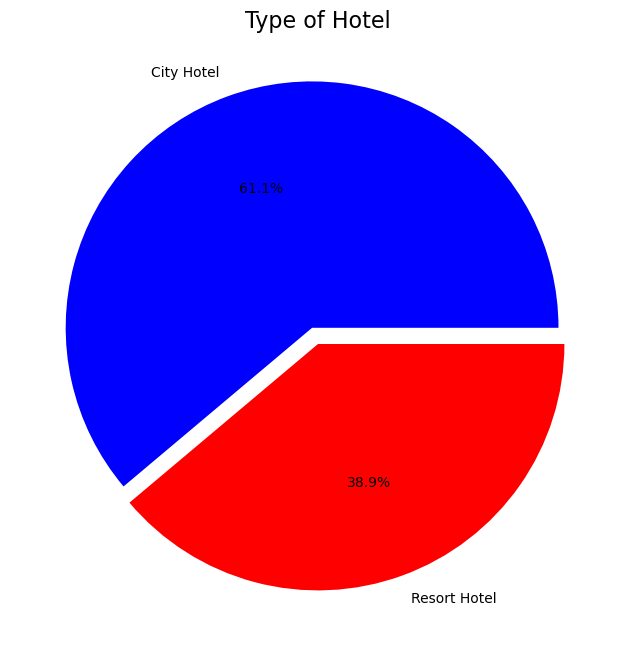

In [14]:
# Hotel Proportion 
hotel = booking_data.reset_index().groupby("hotel").aggregate({"hotel":"count"}).rename(columns={'hotel':'count','index':'hotel'})
hotel = hotel.sort_values('count', ascending=False).reset_index()

plt.figure(figsize=(8,8))
explode = [0.07,0]
labels = hotel["hotel"]
colors = ['blue','Red']
plt.pie(hotel["count"],autopct='%.1f%%', explode=explode, labels=labels, colors=colors)
plt.title(label="Type of Hotel",fontsize=16)

plt.show()

## Pie Chart Representation
- This chart shows the booking percentages for City Hotel and Resort Hotel
61.1% for city and 38.9% for resort, showing city hotel has more booking

## Which country has the highest booking?

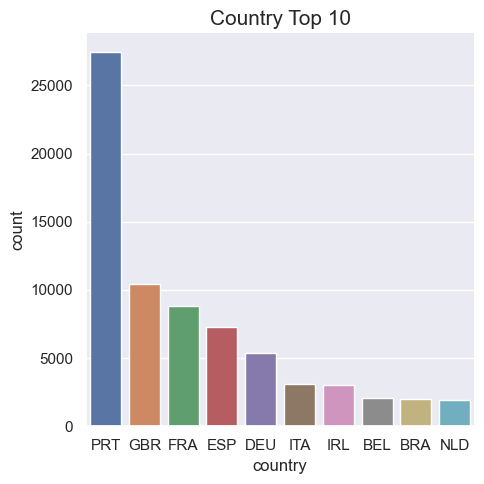

In [15]:
where = booking_data["country"].fillna({"country":"unknown"}).reset_index()
where = where.groupby("country").aggregate({"country":"count"})
where = where.rename(columns={'country':'count','index':'country'}).reset_index().sort_values('count',ascending=False)

sns.set(style='darkgrid')
sns.catplot(x="country",y="count", kind="bar", data=where.head(10))
plt.title(label="Country Top 10", loc="center",fontsize=15)
plt.tight_layout()

plt.show()

This chart shows that Portuguese has the highest quest in booking an hotel

## How many booking was cancelled?

* Overall, 24025 bookings were canceled, accounting for 27 percent of booked stays.


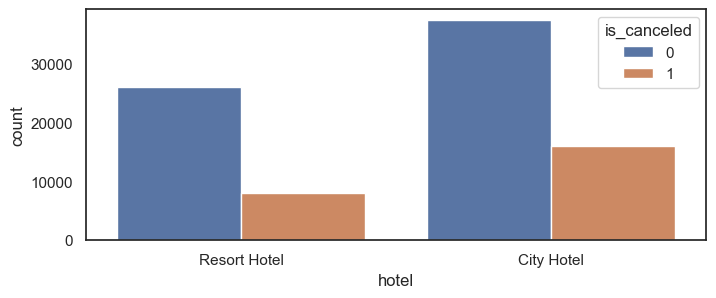

In [16]:
booking_data['pax'] = booking_data.children=booking_data.adults
booking_data['stay_nights'] = booking_data.stays_in_week_nights+booking_data.stays_in_weekend_nights
booking_data['bill']=booking_data.stay_nights*booking_data.adr
booking_data['room_assignment'] = booking_data['reserved_room_type']==booking_data['assigned_room_type']
print('* Overall, %2.0f bookings were canceled, accounting for %2.0f percent of booked stays.'
     %(booking_data.is_canceled.sum(), booking_data.is_canceled.mean()*100))
plt.figure(figsize=(8,3))
sns.set_style("white")
sns.countplot(x='hotel',hue='is_canceled',data=booking_data)
plt.show()

It shows that City Hotel had  24,025 bookings that was cancelled compared to Resort Hotel of 28,000 bookings that was cancelled. 

## How does cancellation affects the financial state of the hotel?

Cancellation Financial Impact


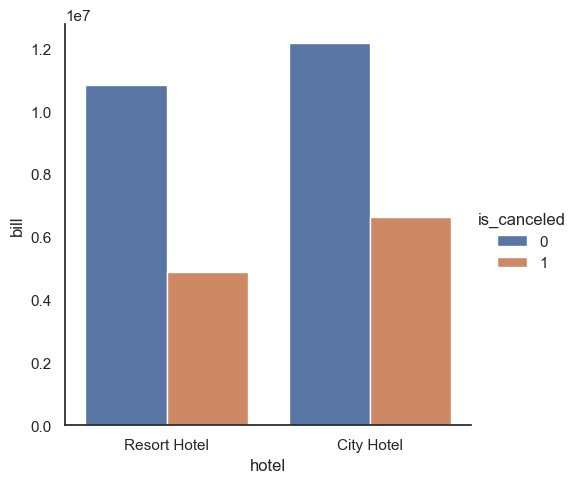

In [17]:
print('Cancellation Financial Impact')
sns.catplot(x='hotel',y='bill',hue='is_canceled',estimator=sum,ci=None,kind='bar',data=booking_data)
plt.show()

The cancellation affects City Hotel more than the Resport Hotel

# Which month and year does Cancellation affect most?

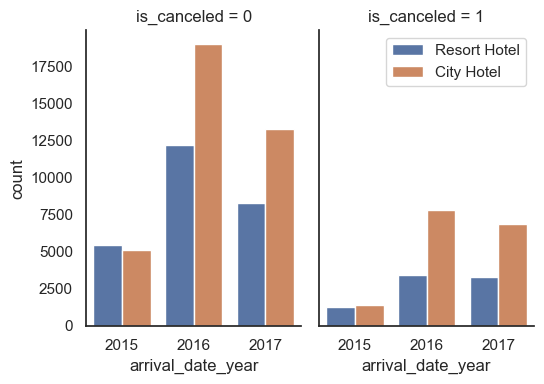

In [18]:
Can_data = booking_data.reset_index()
cancellations = Can_data[['hotel', 'is_canceled','arrival_date_year','arrival_date_month']]
sns.catplot(x='arrival_date_year',col='is_canceled',
           data=cancellations,hue='hotel',kind='count',height=4,aspect=.7,legend=False)
plt.legend(loc='upper right')
plt.show()


2016 has the most cancelled year of Booking in City Hotel

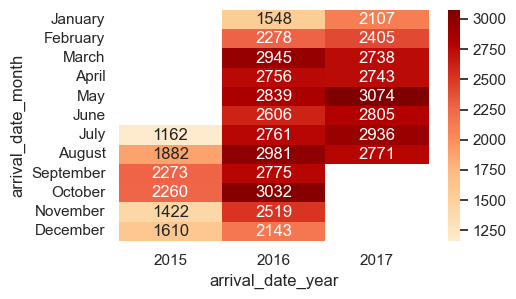

In [19]:
bookings = booking_data[booking_data['is_canceled']==0].pivot_table(index='arrival_date_month',columns='arrival_date_year',values='hotel',
                                                                   aggfunc=len, fill_value=0)
bookings.index = pd.CategoricalIndex(bookings.index,categories=['January','February','March','April','May','June','July','August',
                                                                'September','October','November','December'], ordered = True)
bookings = bookings.sort_index()
mask = np.array([[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[0,0,0],[0,0,0],[0,0,1],[0,0,1],[0,0,1],
                [0,0,1]]) 
## script creates a mask to hide the cells with no bookings. The mask is a NumPy array with the same dimensions as the heatmap, with a value of 1 for cells with bookings and a value of 0 for cells without bookings.


f,ax = plt.subplots(figsize=(5,3))
sns.heatmap(bookings, center=2000,annot=True,mask=mask,fmt='d',ax=ax,cmap='OrRd')
sns.set_context('paper')
plt.show()

This matrix shows that the number of fulfilled reservation peak each year at the months of May and October.

## What are the most important columns for our prediction?

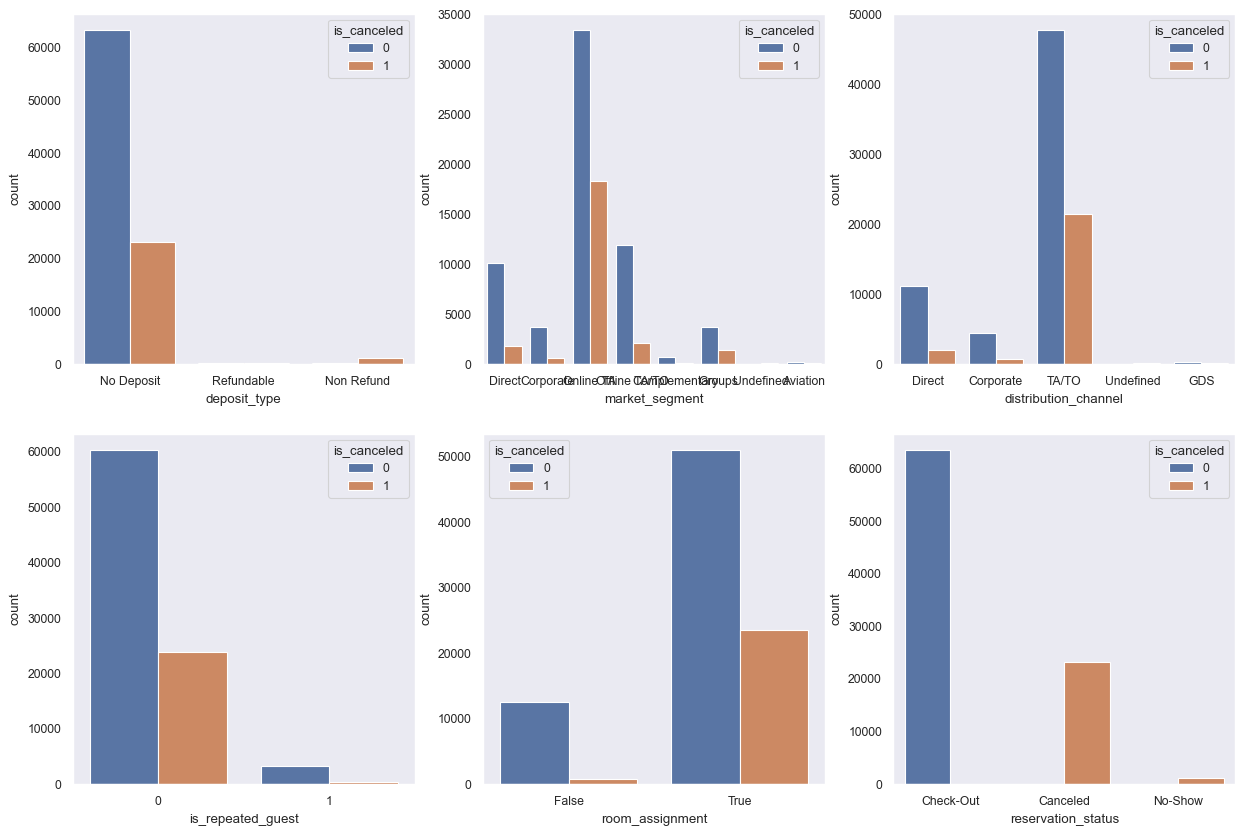

In [20]:
sns.set_style('dark')
fig, axes = plt.subplots(2,3, figsize=(15,10))
sns.countplot(data=booking_data, x='deposit_type',hue='is_canceled', ax=axes[0][0])
sns.countplot(data=booking_data, x='market_segment',hue='is_canceled', ax=axes[0][1])
sns.countplot(data=booking_data, x='distribution_channel',hue='is_canceled', ax=axes[0][2])
sns.countplot(data=booking_data, x='is_repeated_guest',hue='is_canceled', ax=axes[1][0])
sns.countplot(data=booking_data, x='room_assignment',hue='is_canceled', ax=axes[1][1])
sns.countplot(data=booking_data, x='reservation_status',hue='is_canceled', ax=axes[1][2])

plt.show()

### Some insights:
- In regards to 'deposit_type', non refund bookings are canceled almost all the time. 
- Cancellation rate varies a lot for different values of market_segment and distribution channel.
- Repeated guests cancel their bookings less than non-repeated guests

Text(0.5, 1.0, 'Market Segment Breakdown')

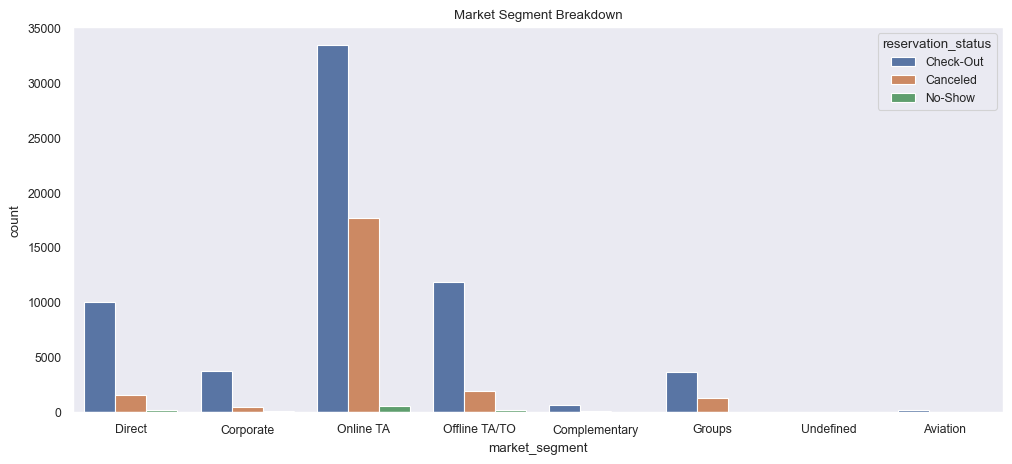

In [21]:
plt.figure(figsize=(12, 5))
sns.countplot(x='market_segment', hue='reservation_status', data=booking_data)
plt.title('Market Segment Breakdown')


Based on this chart, the largest market segment is the online travel agents. People find online travel agents to help book for the best hotel value.  Some people today still use Travel Agents as they book hotels. 

Text(0.5, 1.0, 'Distribution Channels')

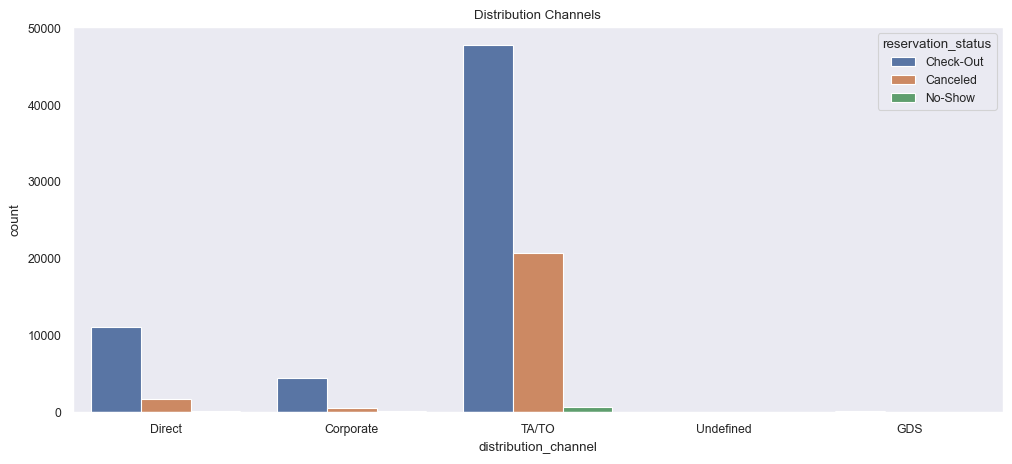

In [22]:
plt.figure(figsize=(12, 5))
sns.countplot(x='distribution_channel', hue='reservation_status', data=booking_data)
plt.title('Distribution Channels')

To confiurm, the travel agents and tour operators are the most popular distribution channels. 

Text(0.5, 1.0, 'Lead Time by Cancellation')

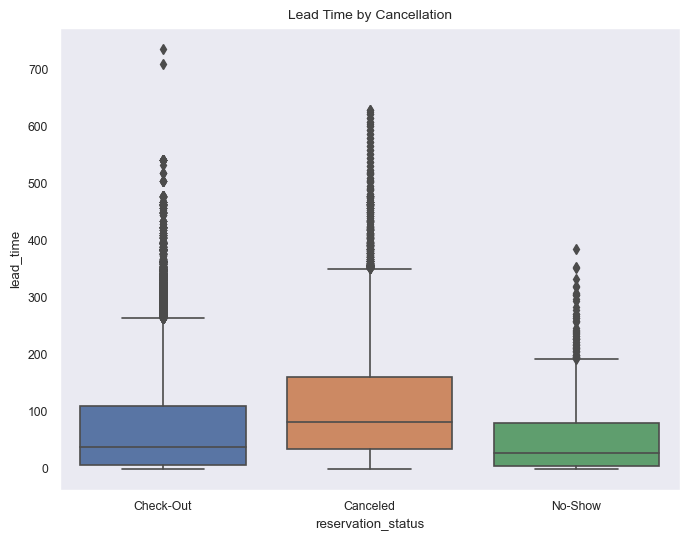

In [23]:
# deploying a boxplot for the booking status
plt.figure(figsize=(8, 6))
sns.boxplot(x='reservation_status', y='lead_time', data=booking_data)
plt.title('Lead Time by Cancellation', fontsize=10)


**Bivariate Analysis:**

This shows an interesting insight about cancellations and the 'lead time.' As a reminder, the lead time is the elapsed time between the booking and arrival date. 
There seems to be a higher cancellation rate when the lead time is longer. 

# Building a Decision Tree Classifier

In [24]:
# preparing the inputs 
bookings = booking_data[['is_canceled', 'lead_time', 'country', 'hotel', 'market_segment', 'distribution_channel', 'room_assignment', 'deposit_type', 'customer_type', 'is_repeated_guest']]
booking_data_dummies=pd.get_dummies(data=bookings, columns=['hotel', 'country', 'market_segment', 'distribution_channel', 'room_assignment', 'deposit_type', 'customer_type', 'is_repeated_guest'])
print(booking_data_dummies.shape)


(87396, 206)


## **Preprocessing**

In [32]:
X = booking_data_dummies.drop(['is_canceled'],axis=1).values
y = booking_data_dummies.is_canceled
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [33]:
# get the shape of train and test data
print('train size X: ',X_train.shape)
print('train size y: ',y_train.shape)
print('test size X: ',X_test.shape)
print('test size y: ',y_test.shape)
     

train size X:  (61177, 205)
train size y:  (61177,)
test size X:  (26219, 205)
test size y:  (26219,)


## Define the model 

In [61]:
# Create a decision tree classifier
model_t = DecisionTreeClassifier(criterion='entropy', random_state=7)

dec_pipe = make_pipeline(scaler,model_t)

# Fit the model to the training data
model_t.fit(X_train, y_train)

y_pred = model_t.predict(X_test)

In [62]:
# save the model
import pickle

# Save the model to a file
pickle.dump(model_t,open('model_t.pkl','wb'))

# Evaluating Metrics

In [63]:
print('Score: ', accuracy_score(y_test, y_pred))

Score:  0.7621572142339524


In [64]:
print('Score: ', f1_score(y_test, y_pred))

Score:  0.5095170677992764


In [65]:
# displaying the metrics for the knn model
dec_test_report = classification_report(y_test, y_pred)   
print(f'Decision Tree Test Report: \n {dec_test_report}')  

Decision Tree Test Report: 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84     19024
           1       0.59      0.45      0.51      7195

    accuracy                           0.76     26219
   macro avg       0.70      0.67      0.68     26219
weighted avg       0.75      0.76      0.75     26219



------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.90      0.82     44347
           1       0.46      0.22      0.30     16830

    accuracy                           0.71     61177
   macro avg       0.60      0.56      0.56     61177
weighted avg       0.67      0.71      0.68     61177



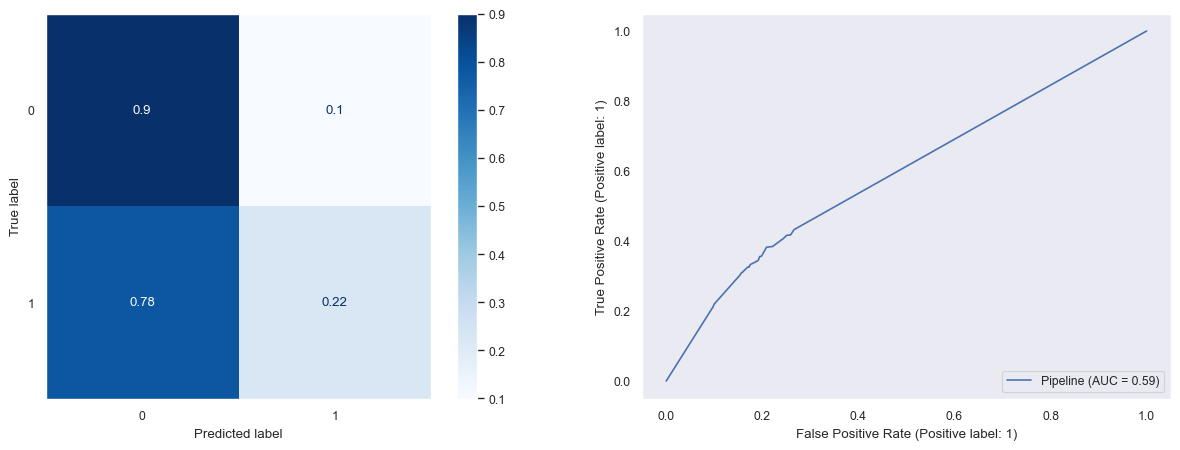

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.89      0.82     19024
           1       0.43      0.21      0.28      7195

    accuracy                           0.71     26219
   macro avg       0.59      0.55      0.55     26219
weighted avg       0.66      0.71      0.67     26219



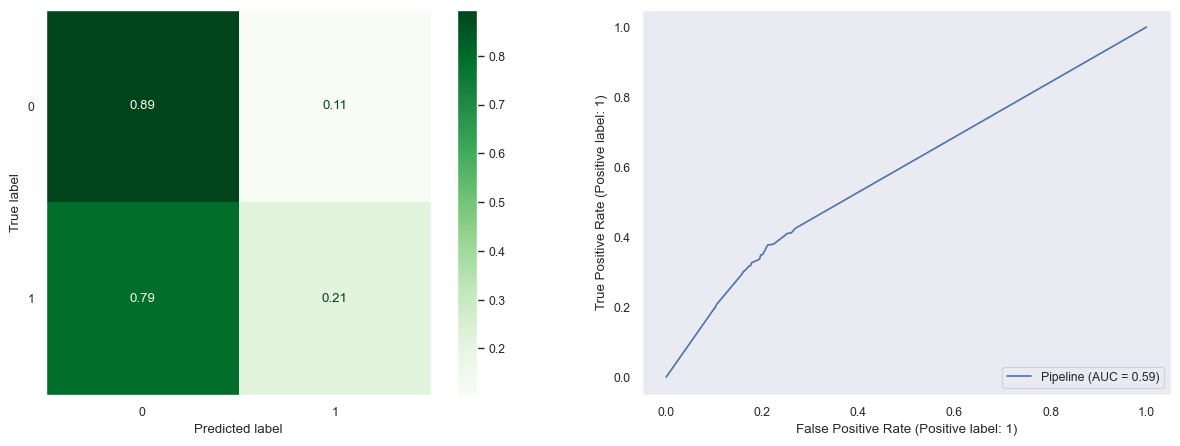

In [66]:
## Use the function twice to evaluate our model on training AND test data
classification_metrics(dec_pipe, X_train,y_train, 
                         cmap='Blues', label='Training Data')
classification_metrics(dec_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

# **K-Nearest Neighbor Model**

## **Base KNN Model**

In [56]:
# Create an instance of the model
knn = KNN()
# Create a model pipeline
knn_pipe = make_pipeline(scaler, knn)
# Fit the model
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [57]:
# Save the model's predictions for the train dataset
knn_train_preds = knn_pipe.predict(X_train)
# Save the model's predictions for the test dataset
knn_test_preds = knn_pipe.predict(X_test)

In [58]:
# Calculate the Confusion Matrices
knn_test_confusion_matrix = confusion_matrix(y_test, knn_test_preds)

In [59]:
# displaying the Confusion Matrices
print(f'KNN Confusion Matrix:\n {knn_test_confusion_matrix}')

KNN Confusion Matrix:
 [[16543  2481]
 [ 3742  3453]]


### **Metrics**

In [60]:
# displaying the metrics for the knn model
knn_test_report = classification_report(y_test, knn_test_preds)   
print(f'KNN Test Report: \n {knn_test_report}')                                   

KNN Test Report: 
               precision    recall  f1-score   support

           0       0.82      0.87      0.84     19024
           1       0.58      0.48      0.53      7195

    accuracy                           0.76     26219
   macro avg       0.70      0.67      0.68     26219
weighted avg       0.75      0.76      0.76     26219



------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     47023
           1       0.94      0.70      0.81     18056

    accuracy                           0.91     65079
   macro avg       0.92      0.84      0.87     65079
weighted avg       0.91      0.91      0.90     65079



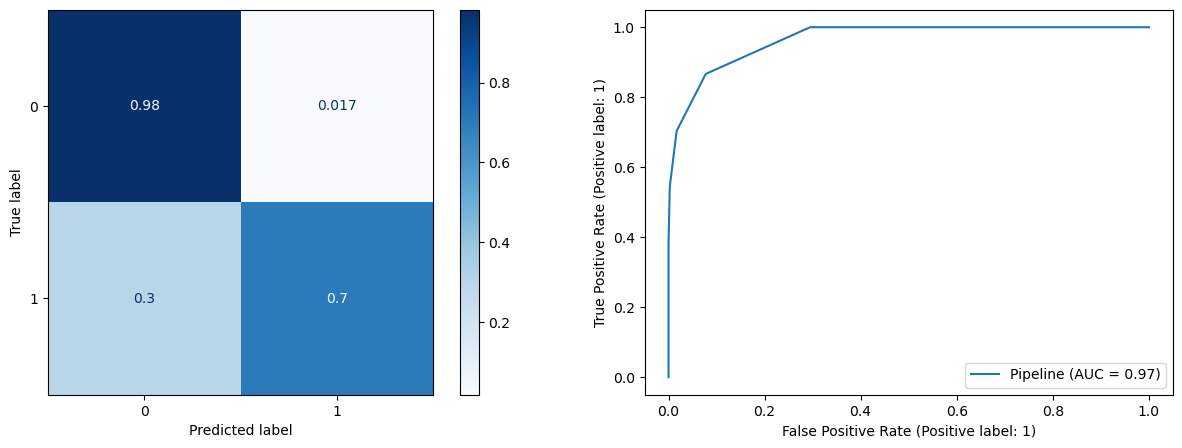

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     15773
           1       0.87      0.61      0.72      5920

    accuracy                           0.87     21693
   macro avg       0.87      0.79      0.82     21693
weighted avg       0.87      0.87      0.86     21693



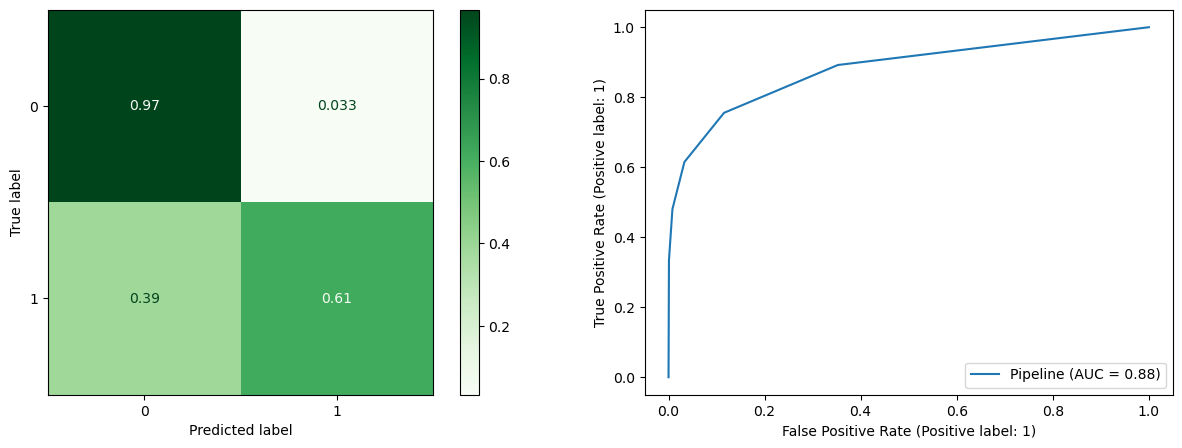

In [139]:
## Use the function twice to evaluate our model on training AND test data
classification_metrics(knn_pipe, X_train,y_train, 
                         cmap='Blues', label='Training Data')
classification_metrics(knn_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

## **Creating a processing pipeline that applies PCA.**

In [140]:
# Create a scaler
scaler = StandardScaler()
# Create a PCA object that will retain 95% of the variance when transforming
pca = PCA(n_components=0.95)
# Combine the scaler and the PCA in a pipeline.
pipe = make_pipeline(scaler, pca)
# Transform the training data and check shape of new features after applying PCA
pipe.fit_transform(X_train)

array([[-0.66585255, -0.59489315,  0.13267009, ..., -0.09043669,
         0.07571043,  1.45305357],
       [-1.52972405, -0.03188487,  0.51057468, ..., -0.79709583,
        -0.01875346,  0.08538197],
       [ 1.12467889,  0.36171185, -1.06422425, ..., -0.95561185,
         0.04264836, -0.18851421],
       ...,
       [ 0.51029937,  1.6850908 , -1.21924058, ...,  0.11102841,
         0.0097663 , -0.03760519],
       [-0.78901328, -0.6145673 ,  0.14234954, ...,  0.12018179,
        -0.3183316 , -1.38362166],
       [ 1.44812883, -0.09006987, -1.98663491, ...,  0.2866603 ,
        -0.34169517, -0.05406927]])

In [141]:
%%time
# Create and fit a KNN model WITH PCA 
knn = KNeighborsClassifier()
pca = PCA() 

knnpca = make_pipeline(pipe, knn)

knnpca.fit(X_train, y_train)

CPU times: user 488 ms, sys: 62.4 ms, total: 550 ms
Wall time: 94.9 ms


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=0.95))])),
                ('kneighborsclassifier', KNeighborsClassifier())])

### **Metrics**

In [142]:
%%time
# Make predictions and evaluate the model using classification_report
pca_pred = knnpca.predict(X_test)

print('PCA Predictions',classification_report(y_test, pca_pred))

PCA Predictions               precision    recall  f1-score   support

           0       0.86      0.95      0.90     15773
           1       0.81      0.58      0.68      5920

    accuracy                           0.85     21693
   macro avg       0.84      0.76      0.79     21693
weighted avg       0.85      0.85      0.84     21693

CPU times: user 13.1 s, sys: 175 ms, total: 13.3 s
Wall time: 2.73 s


## **Tune the Hyperparameters**

In [143]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [144]:
# Tune K utilizing a loop  
krange = range(1,15)
k_list = []
for k in krange:
  knn_pipe = make_pipeline(KNeighborsClassifier(n_neighbors=k))
  knn_pipe.fit(X_train,y_train)
  score = accuracy_score(y_test, knn_pipe.predict(X_test))
  k_list.append(score)

Text(0.5, 1.0, 'Finding the optimal ')

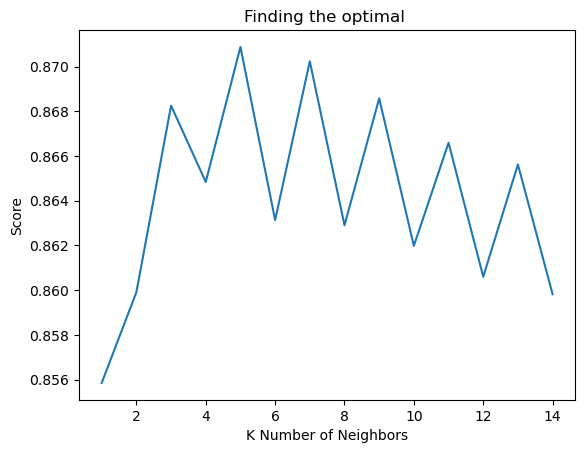

In [145]:
# visualize accuracy scores 
plt.plot(krange, k_list)
plt.xlabel('K Number of Neighbors')
plt.ylabel('Score')
plt.title('Finding the optimal ')

In [146]:
# create an instance of the best model 
knn = KNeighborsClassifier(n_neighbors=10)
# create a model pipeline
knn_pipe = make_pipeline(scaler, knn)
# fit the model
knn_pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

In [147]:
# saving the model's predictions for the train dataset
knn_train_preds = knn_pipe.predict(X_train)
# saving the model's predictions for the test dataset
knn_test_preds = knn_pipe.predict(X_test)

In [148]:
# classification report for the test dataset
knn_test_report = classification_report(y_test, knn_test_preds)

In [149]:
# Print the Classification Report
print('Classification Report for Test\n')
print(knn_test_report)

Classification Report for Test

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     15773
           1       0.92      0.54      0.68      5920

    accuracy                           0.86     21693
   macro avg       0.89      0.76      0.80     21693
weighted avg       0.87      0.86      0.85     21693

